### Machine learning in geoscience with scikit-learn


Matteo Niccoli, MyCarta - Calgary, Alberta, Canada

mycarta.wordpress.com

matteo@mycarta.ca

##### This notebook is intended to show how to use the prediction interval of a regression to discuss economic risk.

Let's first define the prediction interval:

we look at any specific value of x, say x0, and at that x0 we find an interval around the predicted value of y, y0 such that there is a 95% probability that the real value of y in the population (for example, the next well to be drilled) is within this interval.

The larger the interval the greater the uncertainty.

The data we will use comes from this paper: <a href= "http://csegrecorder.com/features/view/value-of-integrated-geophysics-201312"> Many correlation coefficients, null hypotheses, and high value</a> (Lee Hunt, CSEG Recorder, December 2013).


The target variable to be predicted is oil production (measured in tens of barrels of oil per day) from a marine barrier sand. The independent variable is gross pay in meters.

First we import the Python libraries we will need, and the data. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
%matplotlib inline

In [3]:
data = pd.read_csv('Table2_Hunt_2013_edit.csv')

We quickly dispaly some statistics.

In [4]:
data.describe()

,Gross pay,Phi-h,Position,Pressure,Random 1,Random 2,Gross pay transform,Production
count,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000
mean,9.823810,68.880952,1.885714,15.285714,10.190476,292.714286,16.579524,33.428571
std,5.948521,45.167894,0.708721,2.759400,6.439092,59.429069,6.543793,15.141909
min,0.100000,0.500000,1.000000,10.000000,1.000000,210.000000,3.540000,7.710000
25%,4.900000,24.600000,1.100000,14.000000,6.000000,245.000000,11.520000,22.670000
50%,10.000000,72.900000,2.000000,16.000000,10.000000,273.000000,16.900000,36.420000
75%,15.100000,100.000000,2.200000,17.000000,13.000000,340.000000,21.970000,44.200000
max,19.100000,160.000000,2.900000,20.000000,21.000000,395.000000,29.250000,59.200000


And since we are only interested in Production and Gross Pay (the highest predictor, as shown in <a href="https://github.com/mycarta/predict/blob/master/Geoscience_ML_notebook_2.ipynb"> this notebook</a>), we drop the other variables. We also change the index for the wells so as to be one-based (default indexing for Pandas is zero-based).

In [5]:
data = data.drop(['Phi-h','Position','Pressure','Random 1','Random 2','Gross pay transform'], axis=1)
indexed_data = data.set_index([np.arange(1,22,1)])
display(indexed_data)

,Gross pay,Production
1,0.1,15.10
2,1.0,21.30
3,1.9,22.75
4,3.1,15.72
5,4.1,7.71
6,4.9,22.67
7,5.9,18.11
8,7.0,24.30
9,8.1,24.04
10,8.9,25.11


We will use Statsmodels' <a href="http://statsmodels.sourceforge.net/devel/examples/notebooks/generated/ols.html"> Ordinary Least Square</a> to perform the regression and also to derive calculate the prediction interval.

In [6]:
import statsmodels.api as sm

sort_data = indexed_data.sort_values(by='Gross pay', ascending=True)

X = sort_data.loc[:,'Gross pay']
X = sm.add_constant(X, prepend=False) # add intercept
y = sort_data.loc[:,'Production']

model = sm.OLS(y, X)
results = model.fit()
predicted = results.predict()

If you do not want to see a summary of the statistics, comment out the code in the cell below.

In [7]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             Production   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     49.15
Date:                Sun, 13 Nov 2016   Prob (F-statistic):           1.12e-06
Time:                        22:12:20   Log-Likelihood:                -72.940
No. Observations:                  21   AIC:                             149.9
Df Residuals:                      19   BIC:                             152.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Gross pay      2.1617      0.308      7.011      0.0

Now we predict the lower and upper boundaries of the prediction interval.

In [8]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std
pred_std, iv_l, iv_u = wls_prediction_std(results)

We can display the regression with the data and the prediction interval in a single plot.

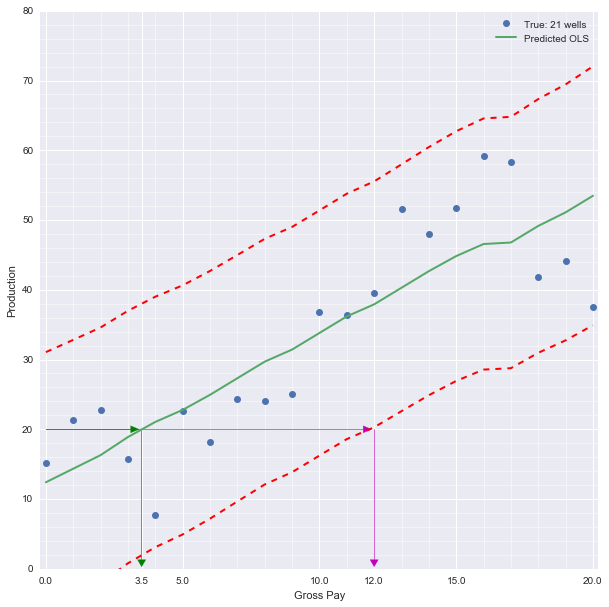

In [9]:
plt.figure(figsize=(10, 10))
ax = plt.subplot(111)
ax.plot(range(21), y, 'o', label = "True: 21 wells")
ax.plot(range(21), predicted, '-', lw=2, label = "Predicted OLS")
ax.plot(range(21), iv_l, 'r--', lw=2)
ax.plot(range(21), iv_u, 'r--', lw=2)
ax.legend(loc='best');
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)

# P.arrow( x, y, dx, dy, **kwargs )
ax.arrow(0,20,3.1,0,fc='g',ec='g',head_width=1, head_length=.3)
ax.arrow(3.5,20,0,-18.7,fc='g',ec='g',head_width=.3, head_length=1)
ax.arrow(0,20,11.6,0,fc='m',ec='m',head_width=1, head_length=.3)
ax.arrow(12,20,0,-18.7,fc='m',ec='m',head_width=.3, head_length=1)
plt.xticks(list(plt.xticks()[0]) + [3.5, 12])
ax.set_xlabel('Gross Pay')
ax.set_ylabel('Production')
ax.set_ylim([0, 80])
ax.set_xlim([-0.2, 20.2])
plt.show()

How do we use this plot? Let's say we have a cutoff of minimum economic production, say for example 20 (bbl/d x10).
With 21 wells the regression would suggest a minimum gross pay of 3.5 m. But if we used the lower boundary of the prediction interval, the 95% confidence level, minimum gross pay would be 12 m.

But, what would happen if we had less wells? Let's say we are in earlier stages of the appraisal process. 
To simulate that, we randomly select only 7 of the 21 wells and repeat the exercise.

In [10]:
np.random.seed(37)
rfew = np.sort(np.random.choice(range(21), 7, replace=False))
print rfew

[ 0  1  4  6  9 18 19]


In [11]:
sort_data_few = sort_data.iloc[rfew]
Xfew = sort_data_few.loc[:,'Gross pay']
Xfew = sm.add_constant(Xfew, prepend=False) # add intercept:
                        
yfew = sort_data_few.loc[:,'Production']

modelfew = sm.OLS(yfew, Xfew)
resultsfew = modelfew.fit()

predictedf = resultsfew.predict()

In [12]:
pred_stdf, iv_lf, iv_uf = wls_prediction_std(resultsfew)

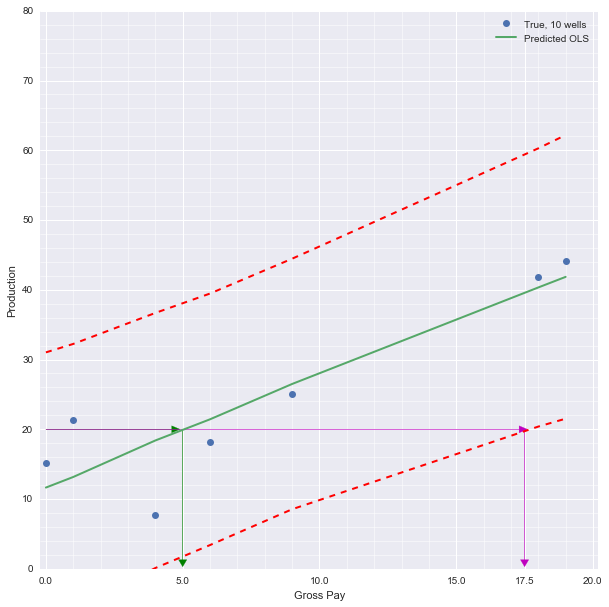

In [13]:
plt.figure(figsize=(10, 10))
ax = plt.subplot(111)
ax.plot(rfew, yfew, 'o', label = "True, 10 wells")
ax.plot(rfew, predictedf, '-', lw=2, label = "Predicted OLS")
ax.plot(rfew, iv_lf, 'r--', lw=2)
ax.plot(rfew, iv_uf, 'r--', lw=2)
ax.legend(loc='best');
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)

# P.arrow( x, y, dx, dy, **kwargs )
ax.arrow(0,20,4.6,0,fc='g',ec='g',head_width=1, head_length=.3)
ax.arrow(5,20,0,-18.7,fc='g',ec='g',head_width=.3, head_length=1)
ax.arrow(0,20,17.3,0,fc='m',ec='m',head_width=1, head_length=.3)
ax.arrow(17.5,20,0,-18.7,fc='m',ec='m',head_width=.3, head_length=1)
plt.xticks(list(plt.xticks()[0]) + [17.5])
ax.set_xlabel('Gross Pay')
ax.set_ylabel('Production')
ax.set_ylim([0, 80])
ax.set_xlim([-0.2, 20.2])
plt.show()

With 10 wells the minimum gross pay suggested by the regression is not a lot higher: 5 m instead of 3.5. However, using the wider prediction interval, now the 95% confidence level, minimum gross pay has gone up from 12 m to 17.5 m.

Perhaps we can live with this. As Hunt suggests in the paper, in the early stages we should understand the statistics, and either choose to accept the statistical nature of the outcomes we endure, improve the conditions of our investigative techniques (or drill more wells), or move on to something else.

Going back to the 21 well example, now confidence is higher, and we can make better conclusions via inductive confirmation:
IF production is higher than 20 (bbl/d x10), then the gross pay will be greater than 12.5 m. Next well drilled has gross pay greater than 9.5 m: we are 95% confident that the production will be higher than the minimum economic of 20 (bbl/d x10).

Notice that in some cases, fewer wells may result in narrower prediction intervals. What you get depends just on the lack of the draw (the random choice of 7 wells). 

To show this variability, the exercise should be done stochastically using many different realizations (choices of 7 random wells) to get a family of widely ranging prediction intervals.

The minimum prediction would be guaranteed only by selecting the most pessimistic (widest) of these intervals (or perhaps the P2.5 of this distribution of prediction intervals).